In [11]:
import pandas as pd
import os
import numpy as np


In [12]:
dir_corr='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/corr_output/'
dir_mi  ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_output/'
dir_nmi_nl ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_nonlinear_output/'
dir_nmi_l  ='/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/nmi_linear_output/'

In [13]:
def combined_csv(data_dir):
    datasets = ['obs', 'merra', 'era', 'clm', 'amip']
    pairs = {
        'swc_rad': ('swc', 'rad'),
        'swc_le':  ('swc', 'le'),
        'swc_sh':  ('swc', 'sh'),
        'swc_gh':  ('swc', 'gh'),
        'rad_le':  ('rad', 'le'),
        'rad_sh':  ('rad', 'sh'),
        'rad_gh':  ('rad', 'gh'),
        'le_sh':   ('le', 'sh'),
        'le_gh':   ('le', 'gh'),
        'sh_gh':   ('sh', 'gh'),
    }

    results_out = {ds: {} for ds in datasets}

    for dataset in datasets:
        for pair_name, (var1, var2) in pairs.items():
            filename1 = f"{dataset}_{var1}_{var2}.csv"
            filename2 = f"{dataset}_{var2}_{var1}.csv"
            path1 = os.path.join(data_dir, filename1)
            path2 = os.path.join(data_dir, filename2)

            if os.path.exists(path1):
                df = pd.read_csv(path1,na_values=-9999)
            elif os.path.exists(path2):
                df = pd.read_csv(path2,na_values=-9999)
            else:
                print(f"⚠️ Missing: {filename1} or {filename2}")
                continue

            results_out[dataset][pair_name] = df
            # print(f"✅ Loaded: {dataset} - {pair_name}")

    return results_out


In [14]:
corr = combined_csv(dir_corr)
mi   = combined_csv(dir_mi)
nmi_nl   = combined_csv(dir_nmi_nl)
nmi_l   = combined_csv(dir_nmi_l)

In [15]:
def elementwise_percent_reduction(mi_dict, nmi_nl_dict):
    """
    total = (1 - nmi_nl/mi) * 100 를 데이터셋/페어별로 원소단위 계산.
    반환: (total_dict, missing_pairs)
    """
    out = {}
    missing = []  # nmi_nl에 없는 (dataset, pair) 기록

    for ds, pairs in mi_dict.items():
        out[ds] = {}
        for pair, df_mi in pairs.items():
            df_nl = nmi_nl_dict.get(ds, {}).get(pair)
            if df_nl is None:
                missing.append((ds, pair))
                continue

            # 인덱스와 컬럼을 교집합으로 정렬(모양 달라도 안전)
            df_mi2, df_nl2 = df_mi.align(df_nl, join='inner', axis=None)

            # 0으로 나누기 방지
            denom = df_mi2.replace(0, np.nan)

            # 원소별 계산
            res = (1 - (df_nl2 / denom)) * 100.0
            
            # if clamp:
            #     # 음수는 0으로, 필요하면 100 초과도 100으로
            res = res.clip(lower=0, upper=None)   # upper=100 도 가능
                
            out[ds][pair] = res

    return out, missing

# 사용 예시
# mi      = combined_csv(dir_mi)
# nmi_nl  = combined_csv(dir_nmi_nl)
total, missing = elementwise_percent_reduction(mi, nmi_nl)

In [16]:
def compute_summary(corr_dict):
    summary_dict = {}
    for pair_name, df in corr_dict.items():
        # Compute quartiles and median for each column and create a summary DataFrame.
        summary_df = pd.DataFrame({'Q1': df.quantile(0.25),
                                    'median': df.median(),
                                    'Q3': df.quantile(0.75)}).T  # Transpose so that the index is ['Q1', 'median', 'Q3'].
        summary_dict[pair_name] = summary_df
    return summary_dict

In [17]:
# Compute summaries for each correlation dictionary.
obs_corr_summary   = compute_summary(corr['obs'])
era_corr_summary   = compute_summary(corr['era'])
merra_corr_summary = compute_summary(corr['merra'])
clm_corr_summary   = compute_summary(corr['clm'])
amip_corr_summary  = compute_summary(corr['amip'])

obs_mi_summary   = compute_summary(mi['obs'])
era_mi_summary   = compute_summary(mi['era'])
merra_mi_summary = compute_summary(mi['merra'])
clm_mi_summary   = compute_summary(mi['clm'])
amip_mi_summary  = compute_summary(mi['amip'])

# obs_nmi_nl_summary   = compute_summary(nmi_nl['obs'])
# era_nmi_nl_summary   = compute_summary(nmi_nl['era'])
# merra_nmi_nl_summary = compute_summary(nmi_nl['merra'])
# clm_nmi_nl_summary   = compute_summary(nmi_nl['clm'])
# amip_nmi_nl_summary  = compute_summary(nmi_nl['amip'])

obs_nmi_l_summary   = compute_summary(total['obs'])
era_nmi_l_summary   = compute_summary(total['era'])
merra_nmi_l_summary = compute_summary(total['merra'])
clm_nmi_l_summary   = compute_summary(total['clm'])
amip_nmi_l_summary  = compute_summary(total['amip'])

In [70]:
obs_nmi_l_summary

{'swc_rad':                 1         2         3          4          5         6  \
 Q1       0.000000  0.000000  0.000000   1.232196   0.000000  0.000000   
 median   3.237998  2.496596  2.449293   5.307194   2.496751  1.639506   
 Q3      10.958438  6.616018  6.889460  10.313957  10.805148  5.671179   
 
                7         8         9        10        11        12  
 Q1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
 median  2.681434  1.585012  3.566527  2.612932  1.701783  0.000000  
 Q3      8.163708  7.045517  7.748389  5.991189  5.934998  5.591084  ,
 'swc_le':                 1          2          3         4          5          6  \
 Q1       0.000000   0.238190   0.000000  0.000000   0.000000   0.000000   
 median   4.572638   6.438253   3.918713  2.680452   6.019060   4.357000   
 Q3      14.558608  13.375559  15.906613  8.634871  14.800488  12.779544   
 
                 7          8          9         10         11         12  
 Q1       0.552246

In [18]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties

In [94]:
def plot_selected_monthly_evolution(obs_corr_summary, era_corr_summary, merra_corr_summary, clm_corr_summary, amip_corr_summary,
                                    obs_mi_summary, era_mi_summary, merra_mi_summary, clm_mi_summary, amip_mi_summary,
                                    obs_nmi_l_summary,era_nmi_l_summary,merra_nmi_l_summary,clm_nmi_l_summary,amip_nmi_l_summary):
    
    selected_keys = ['swc_rad', 'swc_le', 'swc_sh', 'swc_gh']
    titles = ['(a) [SWC, Rn]','(b) [SWC, LE]','(c) [SWC, SH]','(d) [SWC, GH]']
    n_cols = len(selected_keys)
    n_rows = 3  # 1st row: corr, 2nd row: MI

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 8), sharex=True)

    months = np.arange(1, 13)

    for j, key in enumerate(selected_keys):
        # First row: Correlation
        ax_corr = axes[0, j]
        if key in obs_corr_summary:
            ax_corr.plot(months, obs_corr_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_corr_summary:
            ax_corr.plot(months, era_corr_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_corr_summary:
            ax_corr.plot(months, merra_corr_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_corr_summary:
            ax_corr.plot(months, clm_corr_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_corr_summary:
            ax_corr.plot(months, amip_corr_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_corr.set_ylim(-1, 1)
        ax_corr.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax_corr.hlines(0, 0,13, color='black',alpha=0.7)
        ax_corr.set_title(titles[j], fontsize=20, loc='left')
        ax_corr.set_xticks(months)
        ax_corr.set_xlim(0.5, 12.5)
        ax_corr.tick_params(axis="both", which="major", labelsize=15)


        ax_corr.grid(True)
        if j == 0:
            ax_corr.set_ylabel("CORR", fontsize=20)

        # Second row: Mutual Information
        ax_mi = axes[1, j]
        if key in obs_mi_summary:
            ax_mi.plot(months, obs_mi_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_mi_summary:
            ax_mi.plot(months, era_mi_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_mi_summary:
            ax_mi.plot(months, merra_mi_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_mi_summary:
            ax_mi.plot(months, clm_mi_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_mi_summary:
            ax_mi.plot(months, amip_mi_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        ax_mi.set_ylim(0.1, 0.45)
        ax_mi.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

        ax_mi.set_xticks(months)
        ax_mi.set_xlim(0.5, 12.5)
        ax_mi.grid(True)
        ax_mi.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_mi.set_ylabel("NMI", fontsize=20)
            
            
        # Third row: Ratio of linearity
        ax_mi = axes[2, j]
        if key in obs_nmi_l_summary:
            ax_mi.plot(months, obs_nmi_l_summary[key].loc['median'].astype(float).values, color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
        if key in era_nmi_l_summary:
            ax_mi.plot(months, era_nmi_l_summary[key].loc['median'].astype(float).values, color='blue', marker='s', linewidth=2, label='ERA')
        if key in merra_nmi_l_summary:            
            ax_mi.plot(months, merra_nmi_l_summary[key].loc['median'].astype(float).values, color='red', marker='s', linewidth=2, label='MERRA')
        if key in clm_nmi_l_summary:
            ax_mi.plot(months, clm_nmi_l_summary[key].loc['median'].astype(float).values, color='green', marker='x', linewidth=2, label='CLM')
        if key in amip_nmi_l_summary:            
            ax_mi.plot(months, amip_nmi_l_summary[key].loc['median'].astype(float).values, color='orange', marker='+', linewidth=2, label='AMIP')

        if (j == 0) | (j == 3):
            ax_mi.set_ylim(0, 10)
            ax_mi.yaxis.set_major_locator(ticker.MultipleLocator(5))
        else:
            ax_mi.set_ylim(0, 45)
            ax_mi.yaxis.set_major_locator(ticker.MultipleLocator(10))

        ax_mi.set_xticks(months)
        ax_mi.set_xlim(0.5, 12.5)
        ax_mi.grid(True)
        ax_mi.tick_params(axis="both", which="major", labelsize=15)
        if j == 0:
            ax_mi.set_ylabel("Linearity [%]", fontsize=20)
            
        

    # Legend
    handle_obs   = mlines.Line2D([], [], color='gray'  , marker='o', linewidth=10, alpha=0.5, label='OBS')
    handle_merra = mlines.Line2D([], [], color='red'   , marker='s', linewidth=2 , label='MERRA2')
    handle_era   = mlines.Line2D([], [], color='blue'  , marker='s', linewidth=2 , label='ERA5')
    handle_clm   = mlines.Line2D([], [], color='green' , marker='x', linewidth=2 , label='CLM')
    handle_amip  = mlines.Line2D([], [], color='orange', marker='+', linewidth=2 , label='CLM+CAM')

    bold_font = FontProperties(weight='bold', size=18)
    fig.legend(handles=[handle_obs,handle_merra,  handle_era, handle_clm, handle_amip],
               loc='upper center', framealpha=1, prop=bold_font, ncol=5, bbox_to_anchor=(0.5, 0.01))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


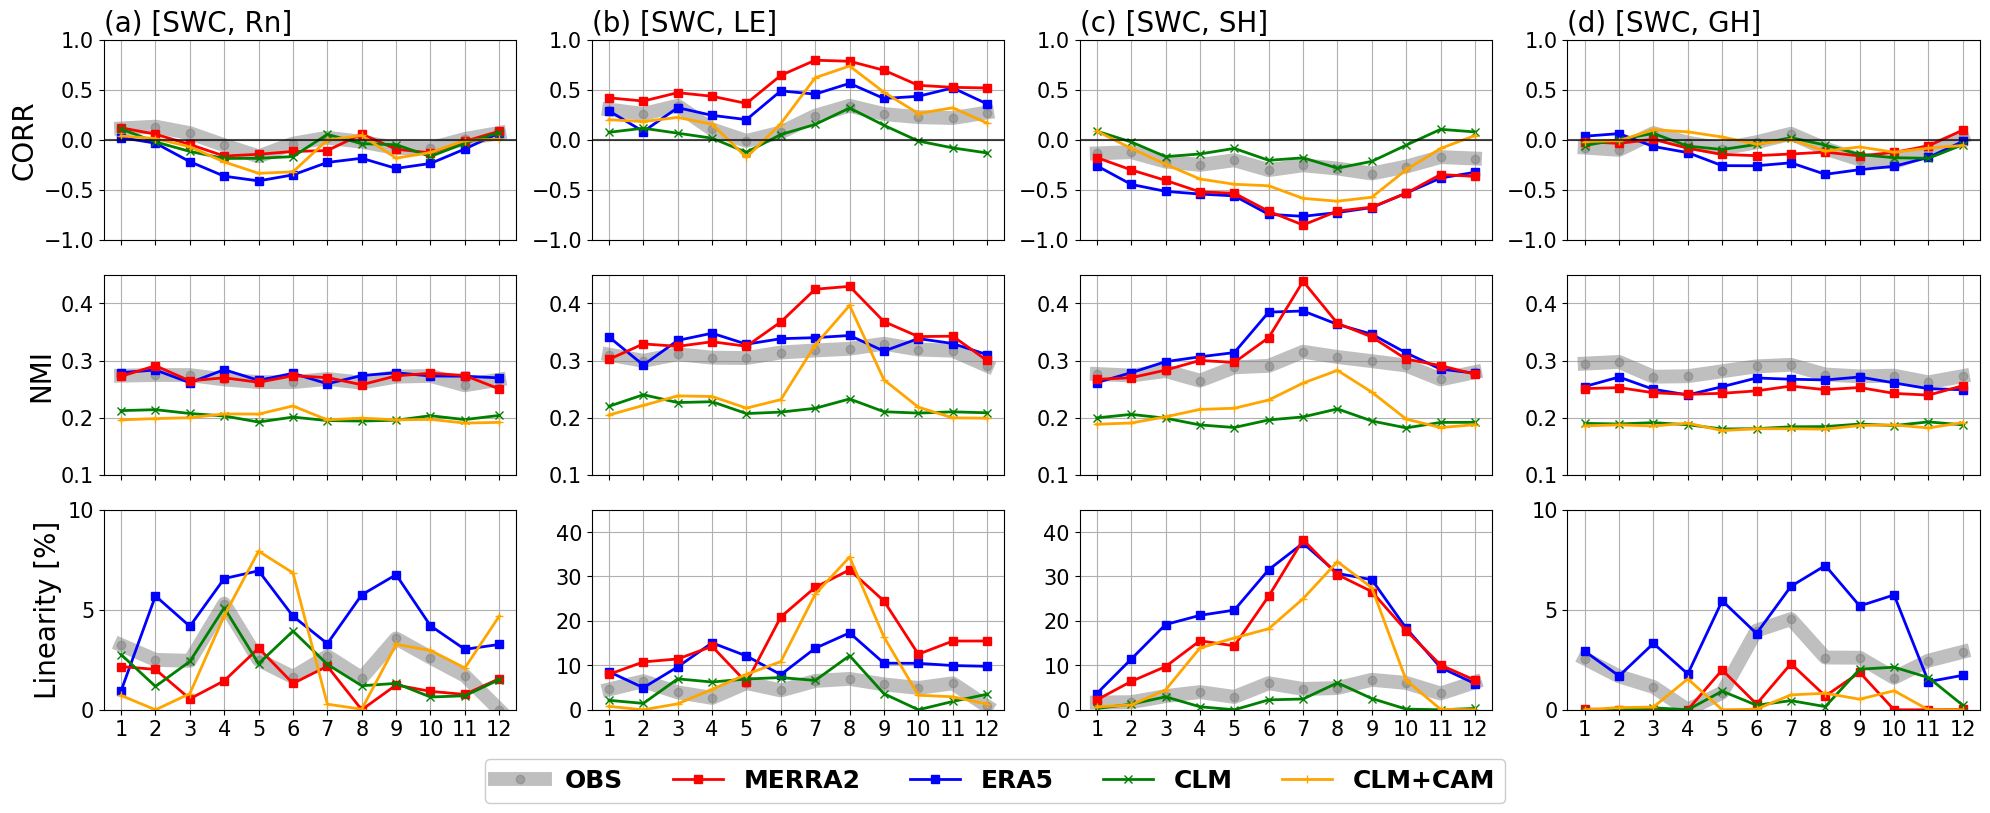

In [96]:
plot_selected_monthly_evolution(
    obs_corr_summary, era_corr_summary, merra_corr_summary,clm_corr_summary, amip_corr_summary,
    obs_mi_summary, era_mi_summary, merra_mi_summary,clm_mi_summary, amip_mi_summary,
    obs_nmi_l_summary,era_nmi_l_summary,merra_nmi_l_summary,clm_nmi_l_summary,amip_nmi_l_summary
)

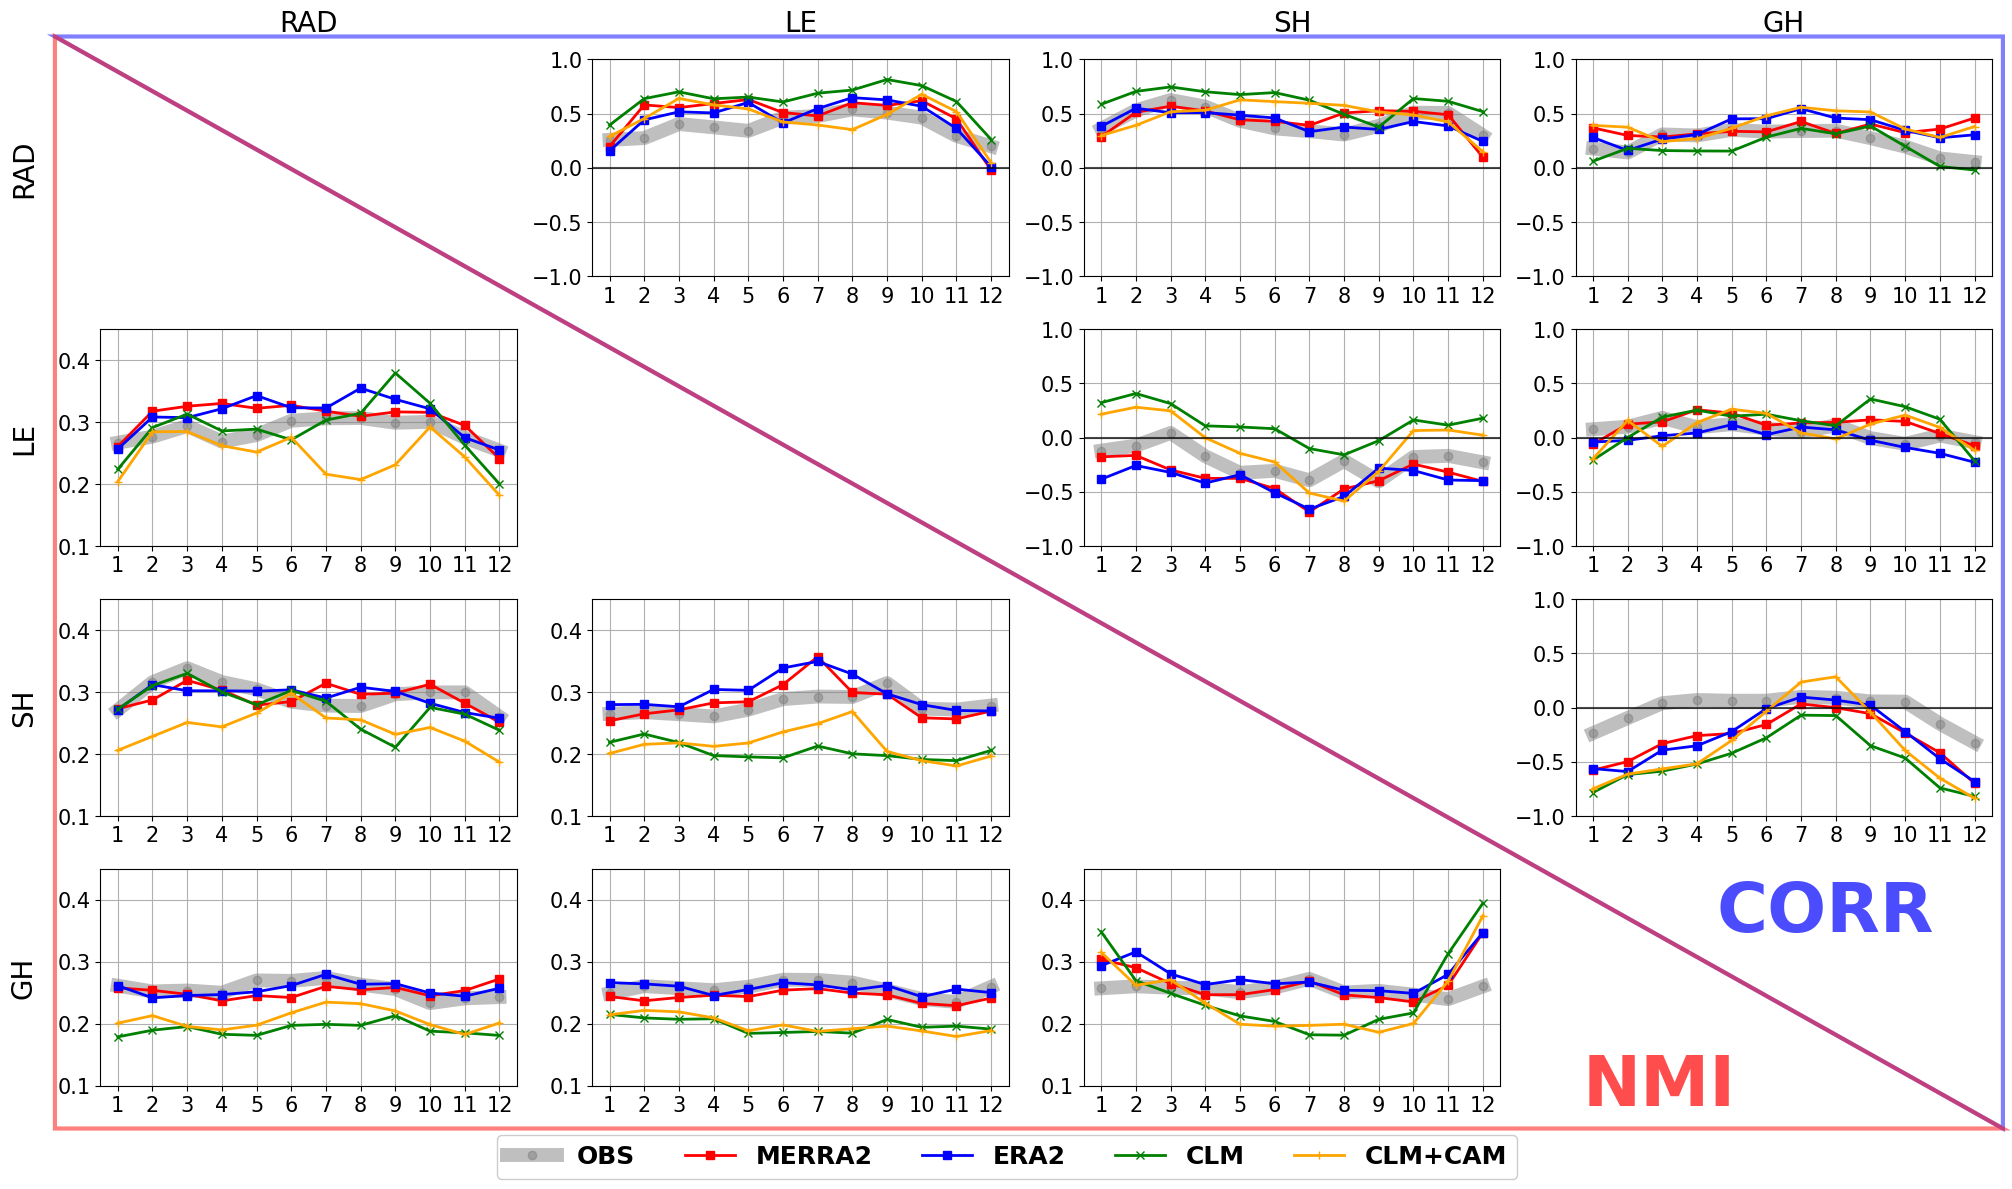

In [19]:
def plot_all_monthly_evolution_matrix(obs_corr_summary, era_corr_summary, merra_corr_summary,
                                      clm_corr_summary, amip_corr_summary,
                                      obs_mi_summary, era_mi_summary, merra_mi_summary,
                                      clm_mi_summary, amip_mi_summary,
                                      variables_order=['rad','le','sh','gh']):

    n = len(variables_order)
    fig, axes = plt.subplots(n, n, figsize=(5*n, 3*n), sharex=False, sharey=False)
    
    # Define x-axis: months 1 to 12.
    months = np.arange(1, 13)
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            # Diagonal cells:
            if i == j:
                # For the top-left cell, remove spines and ticks.
                for spine in ax.spines.values():
                    spine.set_visible(False)
                # ax.yaxis.grid(False)
                # ax.xaxis.grid(False)
                ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=True)
                ax.set_xticks([])
                # ax.set_ylim(-1, 1)
                ax.tick_params(axis='y', colors='white')
            else:
                # Off-diagonal cells: determine the pair key.
                var1 = variables_order[i]
                var2 = variables_order[j]
                key = f"{var1}_{var2}"
                # (If you want to check both orders, uncomment the following two lines.)
                # if key not in obs_corr_summary:
                #     key = f"{var2}_{var1}"
                
                if i > j:
                    if key not in obs_mi_summary:
                        key = f"{var2}_{var1}"
                    if key in obs_mi_summary:
                        df_summary = obs_mi_summary[key]
                        median = df_summary.loc['median'].astype(float).values
                        # q1 = df_summary.loc['Q1'].astype(float).values
                        # q3 = df_summary.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1, q3, linewidth=2, color='black')
                        ax.plot(months, median, marker='o', color='gray', linewidth=10, alpha=0.5, label='OBS')
                    if key in merra_mi_summary:
                        df_summary_merra = merra_mi_summary[key]
                        median_merra = df_summary_merra.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_merra, marker='s', color='red', linewidth=2, label='MERRA2')

                    if key in era_mi_summary:
                        df_summary_era = era_mi_summary[key]
                        median_era = df_summary_era.loc['median'].astype(float).values
                        # q1_era = df_summary_era.loc['Q1'].astype(float).values
                        # q3_era = df_summary_era.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_era, q3_era, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_era, marker='s', color='blue',linewidth=2, label='ERA5')

                    
                    if key in clm_mi_summary:
                        df_summary_clm = clm_mi_summary[key]
                        median_clm = df_summary_clm.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_clm, marker='x', color='green', linewidth=2, label='CLM')

                    if key in amip_mi_summary:
                        df_summary_amip = amip_mi_summary[key]
                        median_amip = df_summary_amip.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_amip, marker='+', color='orange', linewidth=2, label='CLM+AMIP')
                    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
                    ax.set_ylim(0.1, 0.45)

                if i < j:
                    if key not in obs_corr_summary:
                        key = f"{var2}_{var1}"
                    # Plot OBS correlation summary if available.
                    if key in obs_corr_summary:
                        df_summary = obs_corr_summary[key]
                        median = df_summary.loc['median'].astype(float).values
                        # q1 = df_summary.loc['Q1'].astype(float).values
                        # q3 = df_summary.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1, q3, linewidth=2, color='black')
                        ax.plot(months, median, marker='o', color='gray', linewidth=10, alpha=0.5, label='OBS')

                    if key in merra_corr_summary:
                        df_summary_merra = merra_corr_summary[key]
                        median_merra = df_summary_merra.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_merra, marker='s', color='red', linewidth=2, label='MERRA2')

                    if key in era_corr_summary:
                        df_summary_era = era_corr_summary[key]
                        median_era = df_summary_era.loc['median'].astype(float).values
                        # q1_era = df_summary_era.loc['Q1'].astype(float).values
                        # q3_era = df_summary_era.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_era, q3_era, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_era, marker='s', color='blue', linewidth=2, label='ERA5')

                    
                    if key in clm_corr_summary:
                        df_summary_clm = clm_corr_summary[key]
                        median_clm = df_summary_clm.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_clm, marker='x', color='green', linewidth=2, label='CLM')

                    if key in amip_corr_summary:
                        df_summary_amip = amip_corr_summary[key]
                        median_amip = df_summary_amip.loc['median'].astype(float).values
                        # q1_merra = df_summary_merra.loc['Q1'].astype(float).values
                        # q3_merra = df_summary_merra.loc['Q3'].astype(float).values
                        # ax.vlines(months, q1_merra, q3_merra, linewidth=2, color='gray', linestyles='dashed')
                        ax.plot(months, median_amip, marker='+', color='orange', linewidth=2, label='CLM+AMIP')
                    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
                    ax.set_ylim(-1, 1)

                ax.yaxis.grid(True)
                ax.xaxis.grid(True)
                ax.set_xlim(0.5,12.5)
                ax.tick_params(axis="both", which="major", labelsize=15)
                ax.hlines(0, 0,13, color='black',alpha=0.7)
                ax.set_xticks(np.arange(1, 13))
                    # ax.tick_params(axis='y', colors='white')

            # else:
            
            # Label outer plots for clarity.
            if i == 0:
                ax.set_title(variables_order[j].upper(), fontsize=20, pad=20)
            if j == 0:
                ax.set_ylabel(variables_order[i].upper(), fontsize=20)
                ax.yaxis.set_label_coords(-0.15, 0.5)
    
    # Plotting triangles.
    # Adjust edges relative to subplot parameters.
    top_edge   = fig.subplotpars.top   + 0.035
    bot_edge   = fig.subplotpars.bottom - 0.105
    left_edge  = fig.subplotpars.left  - 0.101
    right_edge = fig.subplotpars.right + 0.098

    # Define vertices.
    top_left = (left_edge, top_edge)
    top_right = (right_edge, top_edge)
    bottom_left = (left_edge, bot_edge)
    bottom_right = (right_edge, bot_edge)

    # Triangle 1: blue outline (upper triangle).
    triangle1 = patches.Polygon([top_left, top_right, bottom_right],
                                closed=True, fill=False,zorder=10,
                                edgecolor='blue', alpha=0.5, linewidth=3, facecolor="none",
                                transform=fig.transFigure)
    
    # Triangle 2: red outline (lower triangle).
    triangle2 = patches.Polygon([top_left, bottom_left, bottom_right],
                                closed=True, fill=False, zorder=10,
                                edgecolor='red', alpha=0.5, linewidth=3, facecolor="none",
                                transform=fig.transFigure)
    fig.add_artist(triangle1)   
    fig.add_artist(triangle2)   
    
    # Add text annotations in the lower-right cell.
    axes[3,3].text(0.6, 0.8, "CORR", transform=axes[3,3].transAxes, color='blue', alpha=0.7,
                   ha='center', va='center', fontsize=50, fontweight='bold')
    axes[3,3].text(0.2, 0.0, "NMI", transform=axes[3,3].transAxes, color='red', alpha=0.7,
                   ha='center', va='center', fontsize=50, fontweight='bold')
    
    handle_obs   = mlines.Line2D([], [], color='gray', marker='o', linewidth=10, alpha=0.5, label='OBS')
    handle_merra = mlines.Line2D([], [], color='red', marker='s', linewidth=2, label='MERRA2')
    handle_era   = mlines.Line2D([], [], color='blue', marker='s', linewidth=2, label='ERA2')
    handle_clm   = mlines.Line2D([], [], color='green', marker='x', linewidth=2, label='CLM')
    handle_amip  = mlines.Line2D([], [], color='orange', marker='+', linewidth=2, label='CLM+CAM')

    bold_font = FontProperties(weight='bold', size=18)
    fig.legend(handles=[handle_obs, handle_merra, handle_era, handle_clm, handle_amip],
               loc='upper center', framealpha=1, prop=bold_font, ncol=5, bbox_to_anchor=(0.5, 0.01))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.draw()

# Example usage:
# Assuming obs_corr_summary and era_corr_summary are defined as in your code.
plot_all_monthly_evolution_matrix(obs_corr_summary, era_corr_summary, merra_corr_summary,
                                  clm_corr_summary, amip_corr_summary,
                                  obs_mi_summary, era_mi_summary, merra_mi_summary,
                                      clm_mi_summary, amip_mi_summary)

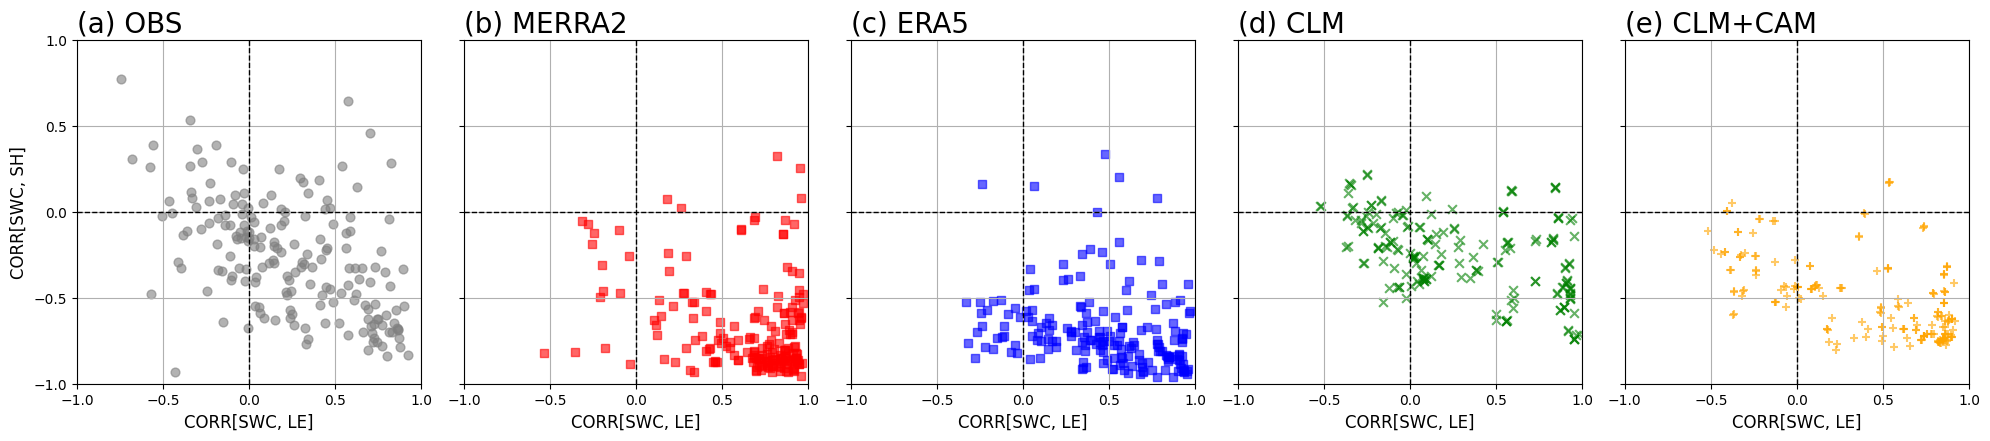

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_scatter_corr_panels(corr_data, months=[6, 7, 8], x_key='swc_le', y_key='swc_sh'):
    datasets = ['obs', 'merra', 'era', 'clm', 'amip']
    titles = ['(a) OBS', '(b) MERRA2', '(c) ERA5', '(d) CLM', '(e) CLM+CAM']
    colors = ['gray', 'red', 'blue', 'green', 'orange']
    markers = ['o', 's', 's', 'x', '+']

    fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        data_x = []
        data_y = []

        for month in months:
            if x_key in corr_data[dataset] and y_key in corr_data[dataset]:
                df_x = corr_data[dataset][x_key]
                df_y = corr_data[dataset][y_key]

                if str(month) in df_x.columns and str(month) in df_y.columns:
                    x_vals = df_x[str(month)].values
                    y_vals = df_y[str(month)].values

                    valid = ~(pd.isna(x_vals) | pd.isna(y_vals))
                    data_x.extend(x_vals[valid])
                    data_y.extend(y_vals[valid])

        ax.scatter(data_x, data_y,
                   color=colors[i],
                   alpha=0.6,
                   s=40,
                   marker=markers[i])
        ax.axhline(0, color='k', linestyle='--', linewidth=1)
        ax.axvline(0, color='k', linestyle='--', linewidth=1)
        ax.set_title(titles[i], fontsize=20,loc='left')
        ax.grid(True)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_aspect('equal')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        if i == 0:
            ax.set_ylabel("CORR[SWC, SH]", fontsize=12)
        ax.set_xlabel("CORR[SWC, LE]", fontsize=12)

    # plt.suptitle("JJA Scatter of CORR[SWC, LE] vs CORR[SWC, SH]", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# 호출
plot_scatter_corr_panels(corr)
